## Q - AC (new scenario)

### Environment

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
import gym
from gym import spaces
import random
from collections import namedtuple
import torch

# Constants used:
TRIALS = 15#60#100#1000
TRIAL_LEN = 4000#50000#500
BATCH_SIZE = 128#32#
NUM_ACCESS_POINTS = 9#3#
NEGATIVE_REWARD = -20000#-15000

TARGET_UPDATE = 10
INPUT_SHAPE = 4
DIAG_DIRECTORY = "torch_diags_10APs/"

# used for cost and migration dictionaries
# LATENCY_MATRIX = [[2.55316, 9.70525, 7.02418],
#                   [9.70525, 2.55389, 6.25835],
#                   [7.02418, 6.26684, 2.55398]]
# PR_LU_TRANS = np.array([
#     [0.35,0.32,0.33],
#     [0.28,0.38,0.34],
#     [0.32,0.29,0.39]])

PR_LU_TRANS = np.array([
    [0.15,0.05,0.1,0.1,0.08,0.12,0.09,0.11,0.2],
    [0.1,0.08,0.12,0.09,0.11,0.03,0.17,0.15,0.15],
    [0.15,0.11,0.03,0.17,0.05,0.1,0.1,0.08,0.21],
    [0.15,0.05,0.1,0.1,0.11,0.03,0.17,0.08,0.21],
    [0.15,0.05,0.1,0.1,0.08,0.12,0.17,0.09,0.14],
    [0.12,0.09,0.15,0.05,0.1,0.1,0.08,0.11,0.2],
    [0.05,0.1,0.1,0.08,0.12,0.15,0.09,0.11,0.2],
    [0.09,0.11,0.03,0.15,0.05,0.1,0.1,0.08,0.29],
    [0.08,0.15,0.05,0.1,0.1,0.12,0.09,0.11,0.2]])
LATENCY_MATRIX = [[2.55316, 9.70525, 7.02418, 2.50611, 8.97695, 4.81203, 6.93397, 6.21317, 7.60077],
                  [9.70525, 2.55389, 6.25835, 11.8198, 7.18656, 3.92144, 6.99266, 6.2124, 6.71018],
                  [7.02418, 6.26684, 2.55398, 4.02147, 3.27882, 2.77404, 4.02353, 5.07656, 2.77417],
                  [2.50611, 11.8198, 4.02147, 2.55354, 9.28922, 7.44114, 9.19819, 4.21866, 11.8622],
                  [8.97695, 7.18656, 3.27882, 9.28922, 2.55301, 3.26512, 2.0394, 5.5403, 5.58373],
                  [4.75385, 3.92267, 2.77457, 7.44114, 3.26512, 2.55366, 1.58549, 3.0197, 2.78874],
                  [6.91204, 7.6288, 4.2441, 9.19819, 2.0394, 1.58474, 2.55359, 3.95576, 4.37348],
                  [6.21317, 6.2124, 5.31069, 4.21866, 6.59593, 3.06604, 3.95576, 2.55396, 5.85478],
                  [7.60077, 6.71018, 2.77417, 11.8622, 5.55827, 2.78874, 4.37348, 5.85478, 2.55313]]

MIGR_COST = np.zeros((NUM_ACCESS_POINTS, NUM_ACCESS_POINTS))
STORAGE_COST_temp = np.zeros((NUM_ACCESS_POINTS))
for p in range(NUM_ACCESS_POINTS):
  diff = random.uniform(-0.5, 0.5)
  STORAGE_COST_temp[p] = 5+diff
  for q in range(NUM_ACCESS_POINTS):
    diff = random.uniform(-0.5, 0.5)
    MIGR_COST[p][q] = LATENCY_MATRIX[p][q]+diff

COST_DICT = MIGR_COST#np.random.rand(NUM_ACCESS_POINTS,NUM_ACCESS_POINTS)
STORAGE_COST = STORAGE_COST_temp#np.random.rand(NUM_ACCESS_POINTS)

ACTUAL_EPS = 0.01#0.15#
GAMMA = 0.9
EPSILON_DECAY = 0.9#0.995 #Exploration vs exploitation
EPSILON_THRESHOLD = 30000

LEARNING_RATE = 0.1 # learning rate
TAU = 0.125
NO_BACKUP = NUM_ACCESS_POINTS#100
BACKUP_ACTION=101
USER_ACC_FACTOR=1.5
K_ = 20

DELTA = 0.005 # lower bound for estimate epsilon
# LAMBDA = 0.7 # eligibility decay rate
# # exploration rate
# EPS=0.03#0.9

# learning rate
ALPHA = 0.05
#ALPHA_T = 0.05
#ALPHA_U = 0.05

#EXPLORATION_FIXED_RATE = 3000

# Calculated:
# states = <Lu,Ls,0/1,backup/not>
NUM_STATES = NUM_ACCESS_POINTS*NUM_ACCESS_POINTS*2*(NUM_ACCESS_POINTS+1)
# actions = <Ls,backup_loc>
NUM_ACTIONS = NUM_ACCESS_POINTS*(NUM_ACCESS_POINTS+1)
n_actions = NUM_ACTIONS

INITIAL_STATE = 0
INITIAL_ACTION = random.randint(0,NUM_ACTIONS-1)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'imp_wt'))

# def conv_to_tensor(x):
#   return torch.tensor([[x]], device=device, dtype = torch.float32)

# def conv_to_tensor2(x):
#   return torch.tensor([x], device=device, dtype = torch.float32)

# Utility function:
def state_transformation(state):
    APlist=list(range(0,NUM_ACCESS_POINTS))
    #create dictionary of states
    StatesDict=list(itertools.product(APlist,APlist))
    actions = list(range( NUM_ACCESS_POINTS))
    actions.append(NO_BACKUP)
    somelists = (
      list(range( NUM_ACCESS_POINTS)),#[0,1, 2],
      list(range( NUM_ACCESS_POINTS)),#[0,1,2],
      [0,1],
      actions#[0,NO_BACKUP] # 'n' refers to no backup.
    )
    stateList0=np.zeros((NUM_STATES,4))
    a=0
    for element in itertools.product(*somelists):
        stateList0[a,:]=element
        # if stateList0[a,2]==1:
        #     self.rsList.append(a)
        a=a+1
    # self.stateList=stateList0
    st = stateList0[state]
    t = torch.tensor(st, dtype=torch.float32)
    # print("torch t:", t)
    return t

# def create_gym_output(x):
#     t = state_transformation(x)
#     lu = int(t[0].item())
#     ls = int(t[1].item())
#     bu = int(t[2].item())
#     buLoc = int(t[3].item())
#     return {
#               "lu":lu,
#               "ls":ls,
#               "bu":bu,
#               "buLoc":buLoc
#             }

# def create_gym_output2(x):
#     t = state_transformation(x)
#     lu = conv_to_tensor2(t[0])#.item())
#     ls = conv_to_tensor2(t[1])#.item())
#     bu = conv_to_tensor2(t[2])#.item())
#     buLoc = conv_to_tensor2(t[3])#.item())
#     return {
#               "lu":lu,
#               "ls":ls,
#               "bu":bu,
#               "buLoc":buLoc
#             }
# def map_state_dict_to_tensor(state):
#     return torch.tensor([
#                           state["lu"],
#                           state["ls"],
#                           state["bu"],
#                           state["buLoc"]
#                         ])
class RLalgo_Env(gym.Env):

    def __init__(self, alpha = ALPHA):
        self.gamma = GAMMA
        self.trials  = TRIALS
        self.trial_len = TRIAL_LEN
        self.totalTS=self.trials*self.trial_len
        # self.dqn_agent=DQN_wrapper()
        # env details!!
        self.numAP=NUM_ACCESS_POINTS
        self.numActions=NUM_ACTIONS
        self.numStates=NUM_STATES
        self.noBackup=NO_BACKUP
        self.delta=DELTA # bounds for estimate epsilon.
        self.userAccFactor=USER_ACC_FACTOR
        self.K = K_
        self.create_dicts()
        self.create_mappings()
        self.alpha = alpha # learning rate
        self.alphaT = alpha#ALPHA_T
        self.alphaU = alpha#ALPHA_U

        self.prev_backup_loc = self.noBackup
        self.t = 0
        # self.create_gym_variables()
    # def create_gym_variables(self):
    #     self.observation_space = gym.spaces.Dict(
    #         {
    #           "lu":gym.spaces.Discrete(NUM_ACCESS_POINTS),
    #           "ls":gym.spaces.Discrete(NUM_ACCESS_POINTS),
    #           "bu":gym.spaces.Discrete(2),
    #           "buLoc":gym.spaces.Discrete(NUM_ACCESS_POINTS+1)
    #         }
    #     )
    #     # self.observation_space = gym.spaces.Discrete(NUM_STATES)
    #     self.action_space = gym.spaces.Discrete(NUM_ACTIONS)
    def create_dicts(self):
        self.pr_lu_trans=PR_LU_TRANS

        self.QEst=np.zeros((self.numStates,self.numActions, self.trials))

        self.anomalySamplingDist=np.zeros((self.numStates,self.totalTS+1))
        self.anomalySamplingDist[:,0]=0.5
        self.actualEPS=ACTUAL_EPS
        self.actualEps=self.actualEPS*np.ones((self.numStates))
        self.U_normal=np.zeros((self.numStates,self.totalTS+1))
        self.T_anomaly=np.zeros((self.numStates,self.totalTS+1))

        self.migrationCost = COST_DICT
        self.commDelay= COST_DICT
        self.storageCost = STORAGE_COST

        self.Reward=np.zeros((self.totalTS+1))
        self.runningAvg=np.zeros((self.totalTS+1))
        self.TDerror=np.zeros((self.totalTS+1))
        self.importanceWeight=np.zeros((self.numStates,self.totalTS+1))
        self.countT=np.zeros((self.numStates))
        self.countNotT=np.zeros((self.numStates))

        self.countState=np.zeros((self.numStates))
        self.whichState=np.zeros((self.totalTS+1))

        self.est11=np.zeros((self.totalTS+1))
        self.steps = []
        self.cur_state=INITIAL_STATE
        
    def create_mappings(self):
        self.rsList=[]
        
        APlist=list(range(0,self.numAP))
        #create dictionary of states
        StatesDict=list(itertools.product(APlist,APlist))
        actions = list(range( NUM_ACCESS_POINTS))
        actions.append(NO_BACKUP)
        somelists = [
          list(range( NUM_ACCESS_POINTS)),
          list(range( NUM_ACCESS_POINTS)),
          [0,1],
          actions#[0,self.noBackup] # 'n' refers to no backup.
        ]
        stateList0=np.zeros((self.numStates,4))
        a=0
        for element in itertools.product(*somelists):
            stateList0[a,:]=element
            if stateList0[a,2]==1:
                self.rsList.append(a)
            a=a+1
        self.stateList=stateList0
        
        self.backup0=101
        actlists = [
            list(range( NUM_ACCESS_POINTS)),
            actions#[self.backup0,self.noBackup]
        ]
        self.actList0=np.zeros((self.numActions,2))
        a=0
        b=0
        for element in itertools.product(*actlists):
            self.actList0[a,:]=element
            a=a+1
        print(self.actList0)

    def set_pointer_to_rl_algo_critic(self, rl_algo_policy):
        self.dqn_agent_policy = rl_algo_policy
    def set_pointer_to_rl_algo_actor(self, rl_algo_policy):
        self.actor_policy = rl_algo_policy

    def get_q_value(self, state, reward):
        value = reward + self.gamma*self.dqn_agent_policy(state)
        return value
    
    def get_action_probs(self, s):
        return self.actor_policy(s)
        # value = reward + self.gamma*self.dqn_agent_policy(map_state_dict_to_tensor(state))
    
    def step(self, action):
        # keep a track of the state counts
        # print("InStep:")
        self.whichState[self.t]=self.cur_state
        self.countState[self.cur_state]+=1
        prevUserLoc=int(self.stateList[self.cur_state][0])
        prevSvcLoc=int(self.stateList[self.cur_state][1])
        newSvcLoc=self.actList0[action][0]
        backupLoc=self.noBackup # initialization
        storCost=0
        if self.actList0[action][1]!=self.noBackup:
            backupLoc=int(self.actList0[action][1])
            storCost=self.storageCost[backupLoc]
        newUserLoc=np.random.choice(np.arange(0,self.numAP), 1, replace=False, p=self.pr_lu_trans[prevUserLoc,:])
        # self.eligibility[cur_state,action,t]=eligibility[cur_state,action,t]+1
        new_state = None
        #if random number is smaller than the sampling prob, rare event has occured
        if random.random()< self.anomalySamplingDist[self.cur_state,self.t]:
            failureLoc= self.actList0[action][0]
            # check if there is backup
            if backupLoc==self.noBackup:
                self.Reward[self.t]=NEGATIVE_REWARD-self.migrationCost[prevSvcLoc,int(newSvcLoc)]
            else:
                backup_migration_cost = 0
                if self.prev_backup_loc != self.noBackup and backupLoc!=self.noBackup and self.prev_backup_loc != backupLoc:#second condition is true for else block
                    backup_migration_cost = self.migrationCost[self.prev_backup_loc,backupLoc]
                if backupLoc==failureLoc: # we dont want this to happen.
                    self.Reward[self.t]= NEGATIVE_REWARD-self.migrationCost[prevSvcLoc,int(newSvcLoc)]-storCost-backup_migration_cost   
                else:
                    self.Reward[self.t]=-self.commDelay[newUserLoc,backupLoc]-self.migrationCost[prevSvcLoc,int(newSvcLoc)]-storCost-backup_migration_cost

            stateName=np.array([newUserLoc,int(newSvcLoc),1,backupLoc])
            new_state=np.where(np.all(self.stateList==stateName,axis=1))[0][0]
    
            #d) compute importance sampling weight.
            
            self.importanceWeight[self.cur_state,self.t]=1.0*self.actualEps[self.cur_state]/self.anomalySamplingDist[self.cur_state,self.t]
            # print("+++++impWt+++++", str(self.importanceWeight[cur_state,t]))
            self.countT[self.cur_state]+=1
        else: # no rare event has occured.
            backup_migration_cost = 0
            if self.prev_backup_loc != self.noBackup and backupLoc!=self.noBackup and self.prev_backup_loc != backupLoc:#second condition is true for else block
                backup_migration_cost = self.migrationCost[self.prev_backup_loc,backupLoc]
            MigrationCost=self.migrationCost[prevSvcLoc,int(newSvcLoc)]
            CommDelayCost=self.commDelay[newUserLoc,int(newSvcLoc)]
            
            self.Reward[self.t]=(-MigrationCost-CommDelayCost)-storCost - backup_migration_cost
        
            stateName=np.array([newUserLoc,int(newSvcLoc),0,backupLoc])
        
            
            new_state=np.where(np.all(self.stateList==stateName,axis=1))[0][0]
        
            # compute importance sampling weight.
            self.importanceWeight[self.cur_state,self.t]=1.0*(1-self.actualEps[self.cur_state])/(1-self.anomalySamplingDist[self.cur_state,self.t])
            # print("+++++impWt+++++", str(self.importanceWeight[cur_state,t]))
            self.countNotT[self.cur_state]+=1
        self.prev_backup_loc = backupLoc
        # if t>EPSILON_THRESHOLD:
        #     self.dqn_agent.eps=max(self.dqn_agent.eps-0.00005,0.01)
        
        for s in range(0,self.numStates):
            self.T_anomaly[s,self.t+1]=self.T_anomaly[s,self.t]
            self.U_normal[s,self.t+1]=self.U_normal[s,self.t]
        
        # # g) update T and U.
        # q_vals = torch.squeeze(self.dqn_agent_policy.q_net(conv_to_tensor2(new_state)))
        # q_vals = None
        # # with torch.no_grad():
        # q_vals = torch.squeeze(self.dqn_agent_policy(create_gym_output2(new_state)))
        # print("Q-Vals = ", q_vals)
        Q_est_temp = self.get_q_value(state_transformation(new_state), self.Reward[self.t])
        # print("Q_est = ", Q_est_temp)
        if new_state in self.rsList:
            # Q_est_temp = max(self.dqn_agent.policy_net(state_transformation(new_state))).item()
            # print(Q_est_temp)
            self.T_anomaly[self.cur_state,self.t+1]=(1-self.alphaT)*self.T_anomaly[self.cur_state,self.t]+self.alphaT*self.actualEps[self.cur_state]*(self.Reward[self.t] +self.gamma*Q_est_temp)
        else:
            # Q_est_temp = max(self.dqn_agent.policy_net(state_transformation(new_state))).item()
            # print(Q_est_temp)
            self.U_normal[self.cur_state,self.t+1]=(1-self.alphaU)*self.U_normal[self.cur_state,self.t]+self.alphaU*(1-self.actualEps[self.cur_state])*(self.Reward[self.t] +self.gamma*Q_est_temp)
        
        # # h) update rare event probs
        # #print('T', T_anomaly[state,t+1], 'U',U_normal[state,t+1] )
        est1=abs(self.T_anomaly[self.cur_state,self.t+1])/(abs(self.T_anomaly[self.cur_state,self.t+1])+abs(self.U_normal[self.cur_state,self.t+1]))
        # #print('t', abs(T_anomaly[state,t+1]))
        # #print('u',abs(U_normal[state,t+1]))
        self.est11[self.t]=est1
        for s in range(0,self.numStates):
            self.anomalySamplingDist[s,self.t+1]=self.anomalySamplingDist[s,self.t]
        self.anomalySamplingDist[self.cur_state,self.t+1]=min(max(self.delta,est1),1-self.delta)
        # #print(anomalySamplingDist[state,t+1])

        # if trial > 15 and self.Reward[self.t]<-600:
        #     print("----------", self.stateList[self.cur_state], "----------", self.actList0[action])
        prev_t = self.t
        prev_st = self.cur_state
        self.t += 1
        self.cur_state = new_state

        if self.t>=1:
            if self.t<self.K:
                self.runningAvg[self.t]=np.average(self.Reward[0:self.t])
            else:
                self.runningAvg[self.t]=np.average(self.Reward[self.t-self.K:self.t])
        # Stuff that only needs to be done for trials, not within a trial:
        if self.t%self.trial_len == 0 and self.t/self.trial_len > 0:
            trial = int(self.t/self.trial_len) - 1
            print("*********************** TRIAL: ", trial, " ***********************")
            for s in range(0,self.numStates):
                    s_Temp = state_transformation(s)
                    # pred = self.dqn_agent_policy.forward(s_Temp)#self.dqn_agent.policy_net(s_Temp)
                    # pred = torch.squeeze(self.dqn_agent_policy.q_net(conv_to_tensor2(s)))
                    pred = None
                    # # with torch.no_grad():
                    # # pred = torch.squeeze(self.actor_policy(create_gym_output2(s)))
                    # _, _, pred = self.actor_policy(create_gym_output2(s))
                    # # above probabilities are log probabilities,
                    # # take exponent to convert to normal domain
                    # pred = np.exp(pred.detach().numpy())
                    pred = self.actor_policy(s_Temp)#.distribution.probs
                    # print("Printing the Actor predictions")
                    # print(pred.shape)
                    print(f"{s} - {pred}")

                    # pred = self.dqn_agent_policy.q_net(conv_to_tensor(s))
                    # print(pred)
                    for a in range(0,self.numActions):
                        # if s in [0,1,2,3,4]:
                        #     print("State: ", str(s), "-----Actions: " , str(a), "-----Pred: ", pred[a])
                        # print(pred[a].item())
                        # print(trial)
                        self.QEst[s,a,trial] = pred[a].item()
            # print(self.QEst[:,:,trial])
        tuple_new_state = state_transformation(prev_st)
        # dict_op = create_gym_output(prev_st)
        # print(type(new_state))
        # return new_state.item(), self.Reward[self.t], False, {}
        # print("MyREW:  ", str(self.Reward[prev_t]), ", ", str(self.importanceWeight[prev_st,prev_t]))
        # print("PritingINFOS:::")
        # print(self.importanceWeight[prev_st,prev_t])
        return tuple_new_state, self.Reward[prev_t], False, {'importance_weight': self.importanceWeight[prev_st,prev_t] }
        
        # tuple_new_state = state_transformation(self.cur_state)
        # dict_op = create_gym_output(self.cur_state)
        # # print(type(new_state))
        # # return new_state.item(), self.Reward[self.t], False, {}
        # print("MyREW:  ", str(self.Reward[self.t-1]), ", ", str(self.importanceWeight[self.cur_state,self.t-1]))
        # return dict_op, self.Reward[self.t], False, {'importance_weight': self.importanceWeight[self.cur_state,self.t] }
    
    def reset(self):
        self.cur_state = INITIAL_STATE
        tuple_new_state = state_transformation(self.cur_state)
        # return self.cur_state
        # return self.cur_state
        return tuple_new_state
        
    def render(self, mode='human'):
        pass
    def close (self):
        pass
    def plot_diags(self):
        plt.plot(self.Reward,'.')
        plt.ylabel('Reward',fontsize=15)
        plt.xlabel('No. of Iterations, x10^3',fontsize=15)
        plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000],['10','20','30','40','50', '60', '70', '80'])
        plt.show()

        plt.plot(self.runningAvg)
        plt.ylabel('Reward, Running Average')
        plt.xlabel('No. of Iterations, 10^3')
        plt.xticks([1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000],['1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60'])
        plt.show()

cpu


### Q-AC our env

Do we need the final Q-values for all states for the online policy or can we use the Actor's policy for that since actor is the one which is supposed to output the actions here?

Variants -
1. Approximate Q-value with V-value from critic
2. Implement Q-AC
3. Experiment with different architectures for Actor and Critic
4. Update stable baselines implementation to include this (override all the variations)

In [ ]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameters
# hidden_size = 256
learning_rate = LEARNING_RATE#0.01#3e-4

# Constants
num_steps = TRIAL_LEN#300
max_episodes = TRIALS#5000

class ActorCritic(nn.Module):
    def __init__(self, num_inputs = 4, num_actions = NUM_ACTIONS):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        # self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        # self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.critic_stack = nn.Sequential(
            nn.Linear(num_inputs, 24),
            nn.ReLU(),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 1)
        )

        self.actor_stack = nn.Sequential(
            nn.Linear(num_inputs, 24),
            nn.ReLU(),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, num_actions)
        )

        # self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        # self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    def get_state_value(self,state):
        value = self.critic_stack(state)
        return value

    def get_action_distr(self,state):
        distr = self.actor_stack(state)
        # print(f"{state}:{distr}")
        # policy_dist = F.softmax(distr, dim=0)
        return distr
    def forward(self, state):
        # state = Variable(state.float().unsqueeze(0))
        # value = F.relu(self.critic_linear1(state))
        # value = self.critic_linear2(value)
        value = self.critic_stack(state)
        # policy_dist = F.relu(self.actor_linear1(state))
        # policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)
        policy = self.actor_stack(state)
        # print("PolicyShape: ",str(policy.shape))
        policy_dist = F.softmax(policy, dim=0)

        return value, policy_dist


In [ ]:
def a2c(env):
    # num_inputs = env.observation_space.shape[0]
    num_outputs = NUM_ACTIONS#env.action_space.n
    
    actor_critic = ActorCritic()
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    env.set_pointer_to_rl_algo_critic(actor_critic.get_state_value)
    env.set_pointer_to_rl_algo_actor(actor_critic.get_action_distr)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0

    for episode in range(max_episodes):
        print(f"**********************************{episode}**********************************")
        log_probs = []
        values = []
        rewards = []
        imp_wts = []

        state = env.reset()
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0]
            # print(value)
            dist = policy_dist.detach().numpy() 

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, infos = env.step(action)
            imp_wt = infos['importance_weight']

            # new_state = new_state_dict)
            rewards.append(reward)
            values.append(value)
            imp_wts.append(imp_wt)

            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
            # print(f"**{steps}--{reward}**")
            if done or steps == num_steps-1:
                Qval, action_probs = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                # print(action_probs)
                if episode % 10 == 0:                    
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            # print(imp_wts[t])
            Qvals[t] = Qval
  
        #update actor critic
        baseline_values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)

        for t in range(len(imp_wts)):
            baseline_values[t] = baseline_values[t] * imp_wts[t]
            # print(imp_wts[t])
        
        advantage = Qvals - baseline_values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

        
    
    # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()

In [ ]:
env = RLalgo_Env()
a2c(env)
# model = A2C_ImpSampling("MultiInputPolicy", obj, learning_rate = 0.01, gamma = 0.85, policy_kwargs= {"net_arch": [24,48,24]} , verbose=1)
#forward)

[[0. 0.]
 [0. 1.]
 [0. 2.]
 [0. 3.]
 [0. 4.]
 [0. 5.]
 [0. 6.]
 [0. 7.]
 [0. 8.]
 [0. 9.]
 [1. 0.]
 [1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]
 [1. 5.]
 [1. 6.]
 [1. 7.]
 [1. 8.]
 [1. 9.]
 [2. 0.]
 [2. 1.]
 [2. 2.]
 [2. 3.]
 [2. 4.]
 [2. 5.]
 [2. 6.]
 [2. 7.]
 [2. 8.]
 [2. 9.]
 [3. 0.]
 [3. 1.]
 [3. 2.]
 [3. 3.]
 [3. 4.]
 [3. 5.]
 [3. 6.]
 [3. 7.]
 [3. 8.]
 [3. 9.]
 [4. 0.]
 [4. 1.]
 [4. 2.]
 [4. 3.]
 [4. 4.]
 [4. 5.]
 [4. 6.]
 [4. 7.]
 [4. 8.]
 [4. 9.]
 [5. 0.]
 [5. 1.]
 [5. 2.]
 [5. 3.]
 [5. 4.]
 [5. 5.]
 [5. 6.]
 [5. 7.]
 [5. 8.]
 [5. 9.]
 [6. 0.]
 [6. 1.]
 [6. 2.]
 [6. 3.]
 [6. 4.]
 [6. 5.]
 [6. 6.]
 [6. 7.]
 [6. 8.]
 [6. 9.]
 [7. 0.]
 [7. 1.]
 [7. 2.]
 [7. 3.]
 [7. 4.]
 [7. 5.]
 [7. 6.]
 [7. 7.]
 [7. 8.]
 [7. 9.]
 [8. 0.]
 [8. 1.]
 [8. 2.]
 [8. 3.]
 [8. 4.]
 [8. 5.]
 [8. 6.]
 [8. 7.]
 [8. 8.]
 [8. 9.]]
**********************************0**********************************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:330: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Streaming output truncated to the last 5000 lines.
1266 - tensor([-10.9482,   7.3138,  -0.4811,   1.1879,   5.3546,   5.9591,   8.6179,
          3.4612,  -2.2994,   1.2177,  -4.0082,  -8.2451,  -9.5964,  -8.2047,
          5.4856,  10.7691,  -8.5237,  -5.7615,   4.6216,  -7.2417,   3.6117,
          8.6352,  -4.9621,   5.8895,   8.7703,   3.7219,   9.6738,   7.4468,
          8.9586,  -6.1624,   2.7758,   7.7874,   6.7806,  -2.7737,  12.3983,
         -3.0117,   3.5696,  12.1680,  -0.5245,  -4.6920,  -4.8997,   2.4881,
          9.9014,  -4.0718,  -7.2302,   6.2878,   5.3430,   8.8759,  -4.0440,
         -9.6072,   6.6071,   6.6974,   4.2402,  -0.9880,  11.6356,  -9.1463,
          8.0119,   9.9638,  -8.6759,  -2.1327,  -3.1767,   6.1838,  -0.1067,
          9.0858,   7.1805,  12.2681,  -7.6522,  12.8736,  -2.3970,  -8.2773,
          3.7976,   6.7673,   6.3444,   5.4110,   5.2647,  11.9851,   1.3213,
         -4.9909,   9.2165,  -6.5701,   0.8476,  -1.8488,   5.0684,  15.2609,
      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


Streaming output truncated to the last 5000 lines.
1319 - tensor([-230.6964,  194.2570,   -9.3190,   94.8212,  170.1267,   94.7598,
         162.7576,  126.6313,  -35.6542,  -59.7516, -114.9754, -200.0361,
        -214.2814, -152.7932,  125.3617,  165.9756, -207.0962, -173.9600,
         118.8532, -191.9978,   39.3727,  171.0835, -173.0434,  147.5143,
         186.7848,  151.4723,  153.3716,  118.3256,  215.8003, -142.9928,
          27.5697,  160.6773,  138.7939, -146.1010,  155.1439,  -28.0532,
         149.6235,  202.0813,   28.5659,  -35.4680,  -86.2389,    5.3244,
         201.3226,  -69.6170, -189.1250,  181.2946,   93.1006,  207.4376,
        -108.1306, -214.9209,  182.3582,  158.1832,   40.8783,  -58.9894,
         211.1617, -158.5310,  189.3278,  127.1073, -137.9771,  -52.5358,
         -19.1500,  147.6482,   -6.8039,  219.7323,  193.7783,  203.6738,
        -149.0768,  260.0621,  -23.5526, -201.7773,  129.3629,  117.5292,
         193.1915,  162.5800,   97.6379,  223.7919,   

KeyboardInterrupt: ignored

In [ ]:
env2 = RLalgo_Env()
a2c(env2)

In [ ]:
env3 = RLalgo_Env()
a2c(env3)

### Plot Reward

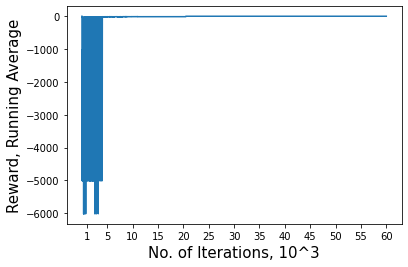

In [ ]:
plt.plot(env.runningAvg)
plt.ylabel('Reward, Running Average',fontsize=15)#
plt.xlabel('No. of Iterations, 10^3',fontsize=15)#
plt.xticks([1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000],['1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60'])
plt.show()

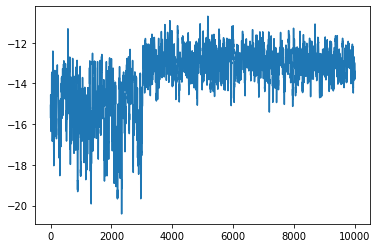

In [ ]:
plt.plot(env.runningAvg[5000:15000])

In [ ]:
print(env.QEst[:, :, 10])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# for s in range(0,NUM_STATES):
#     plt.plot(obj.anomalySamplingDist[s])
# plt.show()

In [ ]:
# for s in range(0,NUM_STATES):
#     plt.plot(obj.U_normal[s])
# plt.show()
# plt.plot(obj.U_normal[0])

In [ ]:
# for s in range(0,NUM_STATES):
#     plt.plot(env.T_anomaly[s])
# plt.show()

In [ ]:
# for s in range(0,NUM_STATES):
#     plt.plot(env.importanceWeight[s])
# plt.show()
#         #     if s not in [0,1,2,5,6,8,10,12,16]:
#         #         continue
#         #     for a in range(0,self.numActions ):
                
#         #         plt.plot(self.QEst[s,a,:])
#         #         name='Q Est, State {}, act {}'.format(s,a)
#         #         plt.ylabel(name)
#         #         plt.xlabel('Time')
#         #         plt.show()
#         #         # name = DIAG_DIRECTORY + "State_"+str(s)+"Action_"+str(a)+".jpg"
#         #         # plt.savefig(name)
#         #         # plt.clf()   
#         #         # plt.plot(np.arange(self.trials-1,self.trials), self.QEst[s,a,self.trials-1:self.trials])
#         #         # name='Q Est, State {}, act {} lastPart'.format(s,a)
#         #         # plt.ylabel(name)
#         #         # plt.xlabel('Time')
#         #         # plt.show()
#         #     # plt.plot(anomalySamplingDist[8,:],'.') 
#         #     # plt.show()


In [ ]:
# for s in range(0,NUM_STATES):
#     plt.plot(env.T_anomaly[s])
# plt.show()

In [ ]:
# plt.plot(env.TDerror)

In [ ]:
# plt.plot(env.est11)

### Online

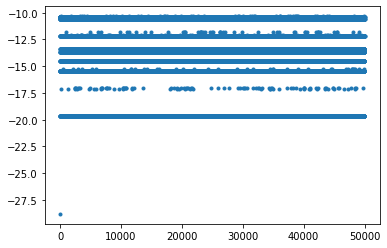

avg reward across time -13.161642193044445


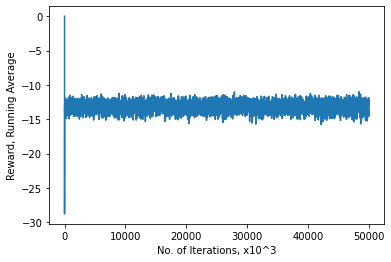

<Figure size 432x288 with 0 Axes>

mean NS reward -13.139174189160514
 mean NS migration -2.828702986137803
 mean NS delay -5.31047120302271
 mean NS storage -5.0


<Figure size 432x288 with 0 Axes>

mean RE reward -15.3505918942721
 mean RE migration -2.828518980886272
 mean RE delay -7.522072913385827
 mean RE storage -5.0


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug  9 18:06:18 2022

@author: Marie
"""
from scipy.special import softmax


# no eligibility traces

import numpy as np
import itertools

import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from statistics import mean

#np.random.seed(4)
#random.seed(3)

# Q_ourAlgo =np.load('Q_ourAlgo.npy')
# Q_BL1= np.load('Q_BL1_c.npy')
Q_ourAlgo = env.QEst[:, :, 4]
policy0=Q_ourAlgo#Q_BL1

NEGATIVE_REWARD = -20000
totalTS=50000
gamma=0.85 #discount factor
# alpha=0.05 # learning rate
# #deltaAlpha=0.0001 #adjustment rate for alpha
# alphaT=0.05
# alphaU=0.05

actualEPS=0.01

delta=0.005 # bounds for estimate epsilon.
lambda_=0.7 #eligibility decay rate
eps=0.9 #exploration rate
K=20

numAP=9#3#9#
#numAnomalyAP=1
numActions=numAP*(1+numAP)
APlist=list(range(0,numAP))
#create dictionary of states
StatesDict=list(itertools.product(APlist,APlist))

numStates=(numAP)*(numAP)*2*(1+numAP)
noBackup=numAP#100
StatesDict=list(itertools.product(APlist,APlist))
actions = list(range( NUM_ACCESS_POINTS))
actions.append(NO_BACKUP)
somelists = [
  list(range( numAP)),#[0,1, 2],
  list(range( numAP)),#[0,1,2],
  [0,1],
  actions#[0,self.noBackup] # 'n' refers to no backup.
]

DIAG_DIRECTORY = 'diags/'
rsList=[]

stateList0=np.zeros((numStates,4))
a=0
for element in itertools.product(*somelists):

    #elem=np.array(element)
    #print(elem)
    stateList0[a,:]=element
    if stateList0[a,2]==1:
        rsList.append(a)
    a=a+1
#stateList=stateList0

backup0=101

actlists = [
    list(range( numAP)),
    actions
]
actList0=np.zeros((numActions,2))
# actList2=np.zeros((numAP*2,2)) # list of actions if there's currently no backup in system

a=0
b=0
for element in itertools.product(*actlists):
    actList0[a,:]=element
    # if actList0[a,1]!=remain:
    #     actList2[b,:]=actList0[a,:]
    #     b=b+1
    a=a+1
    
policy=np.zeros((numStates,numActions))
for n in range(0,numStates):
    policy[n,:]=softmax(policy0[n,:])
    


#edit this later. should be a function of number of BS.
numAnomalyStates=numAP*numAP #EDIT this later.
numNormalStates=numStates-numAnomalyStates

# # ENVIRONMENT
# # g(s'|s): transition prob from all states to anomaly
# g_ss=np.random.rand(numAP,numAnomalyAP) # l_svc stays the same.
# #sum_of_rows = g_ss.sum(axis=1)
# #g_dist=g_ss / sum_of_rows[:, np.newaxis]
# g_dist=normalize(g_ss,axis=1, norm='l1')

#lu_trans=np.random.rand(numAP,numAP-numAnomalyAP)  
#pr_lu_trans=normalize(lu_trans,axis=1, norm='l1')
# pr_lu_trans=np.array([[0.5,0.5,0], [0.15,0.1,0.75], [0.2,0.4,0.4]])
pr_lu_trans=np.array([
    [0.15,0.05,0.1,0.1,0.08,0.12,0.09,0.11,0.2],
    [0.1,0.08,0.12,0.09,0.11,0.03,0.17,0.15,0.15],
    [0.15,0.11,0.03,0.17,0.05,0.1,0.1,0.08,0.21],
    [0.15,0.05,0.1,0.1,0.11,0.03,0.17,0.08,0.21],
    [0.15,0.05,0.1,0.1,0.08,0.12,0.17,0.09,0.14],
    [0.12,0.09,0.15,0.05,0.1,0.1,0.08,0.11,0.2],
    [0.05,0.1,0.1,0.08,0.12,0.15,0.09,0.11,0.2],
    [0.09,0.11,0.03,0.15,0.05,0.1,0.1,0.08,0.29],
    [0.08,0.15,0.05,0.1,0.1,0.12,0.09,0.11,0.2]])

# LATENCY_MATRIX = [[2.55316, 9.70525, 7.02418],
#                   [9.70525, 2.55389, 6.25835],
#                   [7.02418, 6.26684, 2.55398]]
# pr_lu_trans = np.array([
#     [0.35,0.32,0.33],
#     [0.28,0.38,0.34],
#     [0.32,0.29,0.39]])

# pr_lu_trans = PR_LU_TRANS
#ValueEst=np.zeros((totalNStates,totalTS+1))
# QEst=np.zeros((numStates,numActions, totalTS+1))
# QEst[:,:,0]=random.random()*np.ones((numStates,numActions))
#note, we are initialising all to be the same

# anomalySamplingDist=np.zeros((numStates,totalTS+1))
# anomalySamplingDist[:,0]=0.5
#actualEps=delta*np.ones((totalNStates))
actualEps=actualEPS*np.ones((numStates))

# U_normal=np.zeros((numStates,totalTS+1))
# T_anomaly=np.zeros((numStates,totalTS+1))
# eligibility=np.zeros((numStates,numActions,totalTS+1))


#pi(s,a)
#policy=np.random.rand(numStates,numActions)

# reward function:
migrationCost=10*np.random.rand(numAP,numAP)
LATENCY_MATRIX = [[2.55316, 9.70525, 7.02418, 2.50611, 8.97695, 4.81203, 6.93397, 6.21317, 7.60077],
                  [9.70525, 2.55389, 6.25835, 11.8198, 7.18656, 3.92144, 6.99266, 6.2124, 6.71018],
                  [7.02418, 6.26684, 2.55398, 4.02147, 3.27882, 2.77404, 4.02353, 5.07656, 2.77417],
                  [2.50611, 11.8198, 4.02147, 2.55354, 9.28922, 7.44114, 9.19819, 4.21866, 11.8622],
                  [8.97695, 7.18656, 3.27882, 9.28922, 2.55301, 3.26512, 2.0394, 5.5403, 5.58373],
                  [4.75385, 3.92267, 2.77457, 7.44114, 3.26512, 2.55366, 1.58549, 3.0197, 2.78874],
                  [6.91204, 7.6288, 4.2441, 9.19819, 2.0394, 1.58474, 2.55359, 3.95576, 4.37348],
                  [6.21317, 6.2124, 5.31069, 4.21866, 6.59593, 3.06604, 3.95576, 2.55396, 5.85478],
                  [7.60077, 6.71018, 2.77417, 11.8622, 5.55827, 2.78874, 4.37348, 5.85478, 2.55313]]
MIGR_COST = np.zeros((numAP, numAP))
STORAGE_COST_temp = np.zeros((numAP))
for p in range(numAP):
  diff = random.uniform(-0.5, 0.5)
  STORAGE_COST_temp[p] = 5+diff
  for q in range(numAP):
    diff = random.uniform(-0.5, 0.5)
    MIGR_COST[p][q] = LATENCY_MATRIX[p][q]+diff


commDelay=LATENCY_MATRIX#np.array([[2.55316,9.70525, 7.02418], [9.70525, 2.55389,6.25835], [7.02418,6.26684,2.55398]])
migrationCost=MIGR_COST#np.zeros((numAP,numAP))
# for b in range(numAP):
#     for c in range(numAP):
        
#         diff=random.uniform(-0.5,0.5)
#         migrationCost[b,c]=commDelay[b,c]+diff
#         if b==c:
#             migrationCost[b,c]=0
        
#commDelay=0.5*commDelay
#migrationCost=0.5*migrationCost
userAccFactor=1.5
#the further the dist btwn the two AP, the higher the migration cost
# and the higher the comm delay

storageCost=5*np.ones((numAP)) #5*np.random.rand(numAP)

Reward=np.zeros((totalTS))
runningAvg=np.zeros((totalTS))

# initial state
state=random.randrange(0,numStates)
prevSvcLoc=stateList0[state][1]
#action=random.randint(0,numActions-1)
action=np.random.choice(np.arange(0,numActions), 1, replace=False, p=policy[state,:])[0]
Action=np.zeros((totalTS+1))
Action[0]=action #initialising
storCost=0
backupLoc=noBackup
if actList0[action][1]!=noBackup:
    backupLoc=int(actList0[action][1])
    storCost=storageCost[backupLoc]
newSvcLoc=actList0[action][0]
prev_backup_loc = noBackup

# TDerror=np.zeros((totalTS))
# importanceWeight=np.zeros((numStates,totalTS))
countT=np.zeros((numStates))
countNotT=np.zeros((numStates))

countState=np.zeros((numStates))
whichState=np.zeros((totalTS))

# est11=np.zeros((totalTS))

# AStar_tracker=np.zeros((totalTS))

REreward=[]
REmigration=[]
REdelay=[]
REstorage=[]

NSreward=[]
NSmigration=[]
NSdelay=[]
NSstorage=[]

for t in range(0,totalTS):
    
    # if t>30000:
    #     alpha=max(alpha-0.00005,0.005)
    #     alphaT=alpha
    #     alphaU=alpha
    whichState[t]=state
    countState[state]+=1
    prevUserLoc=int(stateList0[state][0])
    prevSvcLoc=int(stateList0[state][1])
    

    # c) go through environment.
    newUserLoc=np.random.choice(np.arange(0,numAP), 1, replace=False, p=pr_lu_trans[prevUserLoc,:])[0]

    
    #eligibility[state,action,t]=eligibility[state,action,t]+1
    
    
    #if random number is smaller than the sampling prob, rare event has occured
    if random.random()< actualEps[state]: #anomalySamplingDist[state,t]:
        failureLoc= actList0[action][0]
        # check if there is backup
        backup_migration_cost = 0
        if backupLoc==noBackup:
            print("NO BACKUP: State: ", stateList0[state], "\t Action: ", actList0[action])
            Reward[t]=NEGATIVE_REWARD-migrationCost[prevSvcLoc,int(newSvcLoc)]
            REstorage.append(0)
        else:
            #Reward[t]=-2000
            #Reward[t]=-userAccFactor*migrationCost[newUserLoc,backupLoc]-storCost
            if prev_backup_loc != noBackup and backupLoc!=noBackup and prev_backup_loc != backupLoc:#second condition is true for else block
                backup_migration_cost = migrationCost[prev_backup_loc,backupLoc]
            if backupLoc==failureLoc: # we dont want this to happen.
                print("BACKUP==FAILURE: State: ", stateList0[state], "\t Action: ", actList0[action])
                Reward[t]= NEGATIVE_REWARD-migrationCost[prevSvcLoc,int(newSvcLoc)]-storCost-backup_migration_cost
                REstorage.append(-storCost)
            else:
                Reward[t]=-commDelay[newUserLoc][backupLoc]-migrationCost[prevSvcLoc][int(newSvcLoc)]-storCost-backup_migration_cost
                REstorage.append(-storCost)
                dela=-commDelay[newUserLoc][backupLoc]
                REdelay.append(dela)
        REreward.append(Reward[t])
        migr=-migrationCost[prevSvcLoc][int(newSvcLoc)]-backup_migration_cost
        REmigration.append(migr)
        
        
        stateName=np.array([newUserLoc,int(newSvcLoc),1,backupLoc])
        nextState=np.where(np.all(stateList0==stateName,axis=1))[0][0]

        # #d) compute importance sampling weight.
        # #if StatesDict[nextState] in AnomalyDict:
        # importanceWeight[state,t]=actualEps[state]/anomalySamplingDist[state,t]
        # #print('importance',importanceWeight[state])
        countT[state]+=1
        
        
        
    else: # no rare event has occured.
        backup_migration_cost = 0
        if prev_backup_loc != noBackup and backupLoc!=noBackup and prev_backup_loc != backupLoc:#second condition is true for else block
            backup_migration_cost = migrationCost[prev_backup_loc][backupLoc]
        MigrationCost=migrationCost[prevSvcLoc][int(newSvcLoc)]+backup_migration_cost
        #print(MigrationCost)
        #userLoc= stateList[state][0]
        # print("new user loc: ", newUserLoc, "+++++++++++++++++++++")
        # print("new serv loc: ", newSvcLoc, "+++++++++++++++++++++")
        CommDelayCost=commDelay[newUserLoc][int(newSvcLoc)]
        #print(CommDelayCost, newUserLoc,int(newSvcLoc) )
        
        Reward[t]=(-MigrationCost-CommDelayCost)-storCost
        NSreward.append(Reward[t])
        NSmigration.append(-MigrationCost)
        NSdelay.append(-CommDelayCost)
        #print(-MigrationCost,-CommDelayCost)
        NSstorage.append(-storCost)
        
        stateName=np.array([newUserLoc,int(newSvcLoc),0,backupLoc])
    
        
        nextState=np.where(np.all(stateList0==stateName,axis=1))[0][0]
    
        # # d) compute importance sampling weight.
        # importanceWeight[state,t]=(1-actualEps[state])/(1-anomalySamplingDist[state,t])
        # #print('importance',importanceWeight[state])
        # countNotT[state]+=1
        
        
    # select action based on s^(t+1)
    #if t>30000:
     #   eps=max(eps-0.00005,0.01)
    
    # if random.random() < eps:
    #     actionNew =random.randint(0, numActions-1)
    # else:        
    #     actionNew=np.argmax(QEst[nextState,:,t])
    #actionNew=np.argmax(policy[nextState,:])
    prev_backup_loc = backupLoc
    actionNew=np.random.choice(np.arange(0,numActions), 1, replace=False, p=policy[nextState,:])[0]
    
    # ****************************************************************************************************CHANGEDDDDDDDDDDDD
    storCost=0
    # if actList0[action][1]!=noBackup:
    #     backupLoc=int(actList0[action][1])
    #     storCost=storageCost[backupLoc]
    if actList0[actionNew][1]!=noBackup:
        backupLoc=int(actList0[actionNew][1])
        storCost=storageCost[backupLoc]

    newSvcLoc=actList0[actionNew][0]
    Action[t+1]=actionNew
    # aStar=np.argmax(QEst[nextState,:,t])
    # AStar_tracker[t]=aStar
    # if QEst[nextState,aStar,t]==QEst[nextState,actionNew,t]:
    #     aStar=actionNew
    #     AStar_tracker[t]=aStar
    
    
    # # e) compute imp sampling TD-error
    # TDerror[t]=importanceWeight[state,t]*(Reward[t] +gamma*QEst[nextState,aStar,t])-QEst[state,action,t]

    
    # for s in range(0,numStates):
        
    #     for a in range(0,numActions):
    #         QEst[s,a,t+1]=QEst[s,a,t]
            
    #     T_anomaly[s,t+1]=T_anomaly[s,t]
    #     U_normal[s,t+1]=U_normal[s,t]
    # QEst[state,action,t+1]=QEst[state,action,t]+alpha*TDerror[t]
    # #print(QEst[state,action,t+1],QEst[state,action,t])
    
    # # g) update T and U.
    # if nextState in rsList:
    #     #alphaT=1/countT[state]*1.1
    #     #alphaT= max(alphaT-deltaT,0.15) 
    #     T_anomaly[state,t+1]=(1-alphaT)*T_anomaly[state,t]+alphaT*actualEps[state]*(Reward[t] +gamma*QEst[nextState,aStar,t+1])
    #     #print('for T', Reward[t] +gamma*QEst[nextState,aStar,t+1],QEst[nextState,aStar,t+1])
    #     #T_anomaly[state,t+1]=(1-alphaT)*T_anomaly[state,t]+alphaT*anomalySamplingDist[state,t]*(Reward[t] +gamma*QEst[nextState,aStar,t+1])
        
    #     #print('Told', (1-alphaT)*T_anomaly[state])
    #     #print('Tnew',alphaT*eligibility[state]*(Reward[t] +gamma*ValueEst[nextState,t+1]))
    # else:
    #     #alphaU= max(alphaU-deltaU,0.15)
    #     U_normal[state,t+1]=(1-alphaU)*U_normal[state,t]+alphaU*(1-actualEps[state])*(Reward[t] +gamma*QEst[nextState,aStar,t+1])
    #     #print('for U', Reward[t] +gamma*QEst[nextState,aStar,t+1], QEst[nextState,aStar,t+1])
    #     #U_normal[state,t+1]=(1-alphaU)*U_normal[state,t]+alphaU*(1-anomalySamplingDist[state,t])*(Reward[t] +gamma*QEst[nextState,aStar,t+1])
        
    #     #print('U new',alphaU*(1-eligibility[state])*(Reward[t] +gamma*ValueEst[nextState,t+1]))
    # # h) update rare event probs
    # #print('T', T_anomaly[state,t+1], 'U',U_normal[state,t+1] )
    # est1=abs(T_anomaly[state,t+1])/(abs(T_anomaly[state,t+1])+abs(U_normal[state,t+1]))
    # #print('t', abs(T_anomaly[state,t+1]))
    # #print('u',abs(U_normal[state,t+1]))
    # est11[t]=est1
    # for s in range(0,numStates):
    #     anomalySamplingDist[s,t+1]=anomalySamplingDist[s,t]
    # anomalySamplingDist[state,t+1]=min(max(delta,est1),1-delta)
   

    
    action=actionNew
    state=nextState
    
    if t>=1:
        if t<K:
            #print(Reward[K-1:K])
            runningAvg[t]=np.average(Reward[0:t])
        else:
            runningAvg[t]=np.average(Reward[t-K:t])

plt.plot(Reward,'.')
plt.show()

print('avg reward across time', np.mean(Reward))

plt.plot(runningAvg)
plt.ylabel('Reward, Running Average')
plt.xlabel('No. of Iterations, x10^3')
plt.show()

#plt.xlabel('Price Pr, Po={}, Qo={}'.format(Po,qo))   
# nameR=DIAG_DIRECTORY + 'QRewardConvg_lr'
# plt.xticks([25000,50000,75000, 100000,125000,150000,175000,200000], ['25', '50', '75','100','125','150','175','200'])#,
# # plt.savefig(nameR, bbox_inches="tight")
# plt.clf()



plt.plot(NSreward)
plt.ylabel('Normal States')
nameR=DIAG_DIRECTORY + 'Norm_St'
# plt.savefig(nameR)
plt.clf()
plt.show()

print('mean NS reward', mean(NSreward))
print(' mean NS migration', mean(NSmigration))
print(' mean NS delay', mean(NSdelay))
print(' mean NS storage', mean(NSstorage))


plt.plot(REreward)
plt.ylabel('Rare Events States')
nameR=DIAG_DIRECTORY + 'Rare_ev_st'
# plt.savefig(nameR)
plt.clf()
plt.show()

print('mean RE reward', mean(REreward))
print(' mean RE migration', mean(REmigration))
print(' mean RE delay', mean(REdelay))
print(' mean RE storage', mean(REstorage))



